In [346]:

from tqdm import tqdm,tnrange
# from pulp import *
from scipy.linalg import expm
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import elitism

import os , time , copy
import pickle , json

# set the random seed:
RANDOM_SEED = 10
random.seed(RANDOM_SEED)

Criteria = "MC"
num_catchments = 7
num_years = 7
Ucost = 1.38
a = 0.1
budgetb = 10000
#budget = [budgetb for i in range(num_years)] #Budget Profile
#budget = [45000,50000,55000,60000,65000,70000,75000] #Budget Profile
Tol=0.15

dfCL = pd.read_pickle(r'dfCL').round(2)
dfT = pd.read_pickle(r'dfT').round(2)

dfT.rename(columns={'SHAPE_Length': 'Len'}, inplace=True)

dfCL = dfCL.iloc[0:num_catchments]
catchments = dfCL.index

dfCL = pd.DataFrame(dfCL)
dfCL.columns = ['Len']

dfT["Tran"] = ""
dfT["Init"] = ""
dfT["Tran"] = dfT["Tran"].astype(object)
dfT["Init"] = dfT["Tran"].astype(object)
dfT["Next"] = ""
dfT["Mean"] = ""
dfT["Next"] = dfT["Next"].astype(object)

dfCL["Tran"] = ""
dfCL["Init"] = ""
dfCL["Next"] = ""
dfCL["Mean"] = ""
dfCL["MeanLen"] = ""
dfCL["PPA"] = ""
dfCL["PPALen"] = ""
dfCL["TPR"] = ""
dfCL["Tran"] = dfCL["Tran"].astype(object)
dfCL["Init"] = dfCL["Init"].astype(object)
dfCL["Next"] = dfCL["Next"].astype(object)
dfCL["TPR"] = dfCL["TPR"].astype(object)


for i in range(len(dfT)):
    a = 1-dfT.Degradation_Rate[i]
    lambda1 = dfT.lambda1[i]
    lambda2 = dfT.lambda2[i]
    lambda3 = dfT.lambda3[i]
    lambda4 = dfT.lambda4[i]
    Q = np.array([[-lambda1, lambda1, 0, 0, 0],
                  [0, -lambda2, lambda2, 0, 0],
                  [0, 0, -lambda3, lambda3, 0],
                  [0, 0, 0, -lambda4, lambda4],
                  [0, 0, 0, 0, 0]])
    Q = Q * 1                ######################################  Degradation Rate Factor #####################
    dfT.Tran[i] = np.around(expm(Q), decimals=3)
    print(np.around(Q, decimals=3))
    print(dfT.Tran[i])
    if np.isnan(np.sum(dfT.Tran[i])):
        dfT.Tran[i]=np.array([[0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1]])


    
    dfT.Init[i]=np.array([0, 0, 0, 0, 0])
    if dfT.Current[i]==0:
        dfT.Init[i][0]=1
    else:
        dfT.Init[i][dfT.Current[i]-1]=1


        
for catchment in catchments:
    dfC = dfT.loc[dfT['Catchment_Group'] == catchment].copy()
    dfC['TranLen']=dfC.Tran*dfC.Len
    STranLen = sum(dfC['TranLen'])
    net_tran = STranLen/np.sum(STranLen,1)
    dfCL.Tran[catchment] = net_tran
   
    dfC['InitLen']=dfC.Init*dfC.Len
    SInitLen=sum(dfC['InitLen'])
    net_init = SInitLen/np.sum(SInitLen)
    dfCL.Init[catchment] = net_init







dfCL_org = dfCL.copy()

S = np.array([1,2,3,4,5])

dfCL = dfCL_org.copy()



# Flushing Transition Matrix
FlushTran = np.array([[1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0]])

def getCatchmentPlan(plan):
    """
    Converts the entire network plan into a dictionary with a separate plan for each catchment
    :param schedule: a list of binary values describing the given schedule
    :return: a dictionary with each catchment as a key and the corresponding plan as the value
    """
    
    catchmentplanDict = {}
    shiftIndex = 0

    for catchment in catchments:
        catchmentplanDict[catchment] = plan[shiftIndex:shiftIndex + num_years]
        shiftIndex += num_years

    return catchmentplanDict

def condition(CatchmentPlan,catchment):
    """
    Calculate the states of each catchment throughout the period according to the plan
    :param CatchmentPlan: a list of binary values describing the catchment plan
    :return: a list of numpy arrays presenting the states in each year
    """
    
    state_list = []
    state = dfCL.Init[catchment]
    for i in range(len(CatchmentPlan)):
        new_state = (1-CatchmentPlan[i])*np.dot(state,dfCL.Tran[catchment])+ CatchmentPlan[i]*np.dot(state,FlushTran)
        state_list.append(new_state)
        state = new_state.copy()
    return state_list

def nextcond():
    dfCL.Next = dfCL.apply(lambda x: np.dot(x.Init, x.Tran), axis=1)
    dfCL.Mean = dfCL.apply(lambda x: (np.dot(S, x.Next.T)), axis=1)
    dfCL.MeanLen = dfCL.Mean*dfCL.Len
    dfCL.PPA = dfCL.apply(lambda x: x.Next[0,3]+x.Next[0,4], axis=1)
    dfCL.PPALen = dfCL.PPA*dfCL.Len
    


def getObjCatchment(CatchmentStates):
    MeanC_Catchment = []
    PPA_Catchment = []
    for i in range(len(CatchmentStates)):
        MeanC_Catchment.append(np.dot(S,CatchmentStates[i].T))
        PPA_Catchment.append(CatchmentStates[i][3]+CatchmentStates[i][4])

    return sum(MeanC_Catchment)/num_years , sum(PPA_Catchment)/num_years , MeanC_Catchment , PPA_Catchment


def getObjCatchment2(CatchmentPlan,catchment):
    dfC = dfT.loc[dfT['Catchment_Group'] == catchment].copy()
    condition_list=[]
    for i in range(len(CatchmentPlan)):
        if CatchmentPlan[i]==1:
            dfC.Next = dfC.apply(lambda x: np.dot(x.Init, FlushTran), axis=1)
        else:
            dfC.Next = dfC.apply(lambda x: np.dot(x.Init, x.Tran), axis=1)
        dfC.Mean = dfC.apply(lambda x: sum(sum((np.dot(S, x.Next.T)))), axis=1)
        obj = sum(dfC.Len*dfC.Mean)/sum(dfC.Len)
        condition_list.append(obj)
        dfC.Init = dfC.Next.copy()
    return sum(condition_list)/len(condition_list)


def BudgetConstraint(catchmentplanDict):
    num_hard_violation = 0
    percent = 0
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        if cost > budgetb*(1+Tol):
            num_hard_violation +=1
            percent += abs(cost-budgetb*(1+Tol))/(budgetb*(1+Tol))
        if cost < budgetb*(1-Tol):
            num_hard_violation +=1
            percent += abs(cost-budgetb*(1-Tol))/(budgetb*(1-Tol))
    
    return num_hard_violation, percent

def BudgetConstraintTotal(catchmentplanDict):
    num_budget_violation = 0
    total_budget_percent = 0
    costT = 0
    budgetTotal = budgetb*num_years
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        costT += cost
    if costT > budgetTotal:
        num_budget_violation +=1
        total_budget_percent += (costT-budgetTotal)/budgetTotal

    
    return num_budget_violation, total_budget_percent

def OneFlushConstraint(catchmentplanDict):
    num_soft_violation = 0
    soft = 0
    for C in catchments:
        if sum(catchmentplanDict[C]) == 0:
            num_soft_violation +=1
            soft += dfCL.Len[C]
    soft_percent = soft/dfCL.Len.sum()       
    return num_soft_violation, soft_percent  



def getObj(plan):
    """
    Calculates the total cost of the various violations in the given network plan
    ...
    :param plan: a list of binary values describing the given network plan
    :return: the calculated cost
    """
    # convert entire schedule into a dictionary with a separate schedule for each catchment:
    catchmentplanDict = getCatchmentPlan(plan)
    MeanC_Catchment_List = []
    PPA_Catchment_List = []
    for C in catchments:
        CatchmentStates = condition(catchmentplanDict[C],C)
        MeanC_Catchment , PPA_Catchment , _ , _  = getObjCatchment(CatchmentStates)
        MeanC_Catchment_List.append(MeanC_Catchment) 
        PPA_Catchment_List.append(PPA_Catchment)
    #print(Obj_Catchment_List)
    if Criteria == "PPA":
        Obj_Network = (sum(np.array(dfCL.Len)*np.array(PPA_Catchment_List)))/sum(dfCL.Len)
    else:
        Obj_Network = (sum(np.array(dfCL.Len)*np.array(MeanC_Catchment_List)))/sum(dfCL.Len)
    
    
    #add penalty for violating constraint
    num_hard_violation , percent_hard_violation = BudgetConstraint(catchmentplanDict)
    num_soft_violation , percent_soft_violation = OneFlushConstraint(catchmentplanDict)
    num_budget_violation, total_budget_percent = BudgetConstraintTotal(catchmentplanDict)
    
    #Obj_Network_WC = Obj_Network+num_hard_violation*HARD_CONSTRAINT_PENALTY+num_soft_violation*SOFT_CONSTRAINT_PENALTY
    Obj_Network_WC = Obj_Network+percent_hard_violation*HARD_CONSTRAINT_PENALTY+percent_soft_violation*SOFT_CONSTRAINT_PENALTY+BUDGET_TOTAL_PENALTY*total_budget_percent
    return Obj_Network_WC , Obj_Network

def getPerformance(plan):
    """
    Calculates the total cost of the various violations in the given network plan
    ...
    :param plan: a list of binary values describing the given network plan
    :return: the calculated cost
    """
    # convert entire schedule into a dictionary with a separate schedule for each catchment:
    
    performance = pd.DataFrame(columns = [i for i in range(1,num_years+1)], index = catchments)
    
    catchmentplanDict = getCatchmentPlan(plan)
    for C in catchments:
        CatchmentStates = condition(catchmentplanDict[C],C)
        _, _, MeanC_Catchment , PPA_Catchment = getObjCatchment(CatchmentStates)
        if Criteria == "PPA":
            performance.loc[C] = [i*dfCL.Len[C]/dfCL.Len.sum() for i in PPA_Catchment]
        else:
            performance.loc[C] = [i*dfCL.Len[C]/dfCL.Len.sum() for i in MeanC_Catchment]
    return performance.sum().tolist()    


def printPlanInfo(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)

    print("Plan for each Catchment:")
    for catchment in catchmentplanDict: 
        print(catchment, ":", catchmentplanDict[catchment])
    print()
    print("Yearly Budget violations = ", BudgetConstraint(catchmentplanDict))
    print()
    print("Total Budget violations = ", BudgetConstraintTotal(catchmentplanDict))
    print()
    print("Minimum flush violations = ", OneFlushConstraint(catchmentplanDict))
    print()
    
    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
    print("Required budget for this plan: ", [round(num, 1) for num in required_budget] )
    print()
    print("Total required budget: ", round(sum(required_budget), 1))
    print()
    Obj_Network_WC , Obj_Network = getObj(plan)
    print("Network objective without penalty: ", Obj_Network )
    print()
    print(pd.DataFrame(np.array(plan).reshape(num_catchments,num_years),index=catchments, columns=range(1,1+num_years)))
    
def printPlanInfo2(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)

    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
        
    Obj_Network_WC , Obj_Network = getObj(plan)

    print(BudgetConstraint(catchmentplanDict),BudgetConstraintTotal(catchmentplanDict),OneFlushConstraint(catchmentplanDict),Obj_Network , round(sum(required_budget), 1))

def Optimizeplan():  
    plan = pd.DataFrame(index = catchments)
    for year in range(1,num_years):
        plan[str(year)]=''
        nextcond()
        model = LpProblem(name="Flushing-Plan", sense=LpMinimize)
        x = {i: LpVariable(name="{0}".format(dfCL.index[i]), lowBound=0, upBound=1, cat=LpInteger ) for i in range(len(catchments))}
        if Criteria == "PPA":        
            model += sum(dfCL.PPALen)-lpDot(dfCL.PPALen.tolist(), x.values())
        else:
            model += sum(dfCL.MeanLen)-lpDot(dfCL.MeanLen.tolist(), x.values())+lpDot(dfCL.Len.tolist(), x.values())
            
        model += (lpDot(dfCL.Len.tolist(), x.values())*Ucost <= budget[year-1] , "Budget Constraint")
        status = model.solve()
        for var in x.values():
            #print(f"{var.name}: {var.value()}")
            if var.value()==1:
                plan[str(year)][var.name]=1
            else:
                plan[str(year)][var.name]=0

        for c in catchments:
            if plan[str(year)][c]==1:
                dfCL['Init'][c] = np.dot(dfCL['Next'][c], FlushTran)
            else:
                dfCL['Init'][c] = dfCL['Next'][c]

    year = num_years
    noflush = []
    noflushcost = []
    for c in catchments:
        if plan.loc[c,:].sum() == 0:
            noflush.append(c)
            noflushcost.append(dfCL.Len[c]*Ucost) 
    if sum(noflushcost) > budget[year-1]:
        print()
        print()
        print('The budget is not enough for the remaining catchments')
        print()
        print()

    plan[str(year)]=''
    nextcond()
    model = LpProblem(name="Flushing-Plan", sense=LpMinimize)
    x = {i: LpVariable(name="{0}".format(dfCL.index[i]), lowBound=0, upBound=1, cat=LpInteger ) for i in range(len(catchments))}
    if Criteria == "PPA":        
        model += sum(dfCL.PPALen)-lpDot(dfCL.PPALen.tolist(), x.values())
    else:
        model += sum(dfCL.MeanLen)-lpDot(dfCL.MeanLen.tolist(), x.values())+lpDot(dfCL.Len.tolist(), x.values())
    model += (lpDot(dfCL.Len.tolist(), x.values())*Ucost <= budget[year-1] , "Budget Constraint")
    for c in noflush:
        catchmentlist = catchments.values.tolist()
        model += (x[catchmentlist.index(c)] == 1)
    status = model.solve()
    for var in x.values():
        #print(f"{var.name}: {var.value()}")
        if var.value()==1:
            plan[str(year)][var.name]=1
        else:
            plan[str(year)][var.name]=0
    
    return planlist(plan)

def planlist(plan):
    sol = []
    for c in catchments:
        for year in range(1,num_years+1):
            sol.append(plan[str(year)][c])
    return sol




Tplan = []
for i in range(2**num_years):
    strplan = (format(i, '0'+str(num_years)+'b'))
    plan = [int(j) for j in strplan]
    Tplan.append(plan)
    


for C in tqdm(catchments):
    TPR = []
    for p in Tplan:
        dfCL = dfCL_org.copy()
        CatchmentStates = condition(p,C)
        MeanC_Catchment , _ , _ , _  = getObjCatchment(CatchmentStates)
        TPR.append(MeanC_Catchment)
    dfCL_org.TPR[C] = np.array(TPR)

    
Cost = {}
for x in range(1, num_years+1):
    y = []
    for p in Tplan:
        y.append(p[x-1])
    Cost["{0}".format(x)] = y
    
    
def PlanInfo(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)
    
    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
        
    _ , Obj_Network = getObj(plan)
    return Obj_Network , round(sum(required_budget), 3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9872\259204390.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfT.Tran[i] = np.around(expm(Q), decimals=3)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9872\259204390.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfT.Init[i]=np.array([0, 0, 0, 0, 0])


[[-0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0.  0.]
 [ 0.  0. -0.  0.  0.]
 [ 0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[-0.23  0.23  0.    0.    0.  ]
 [ 0.   -0.18  0.18  0.    0.  ]
 [ 0.    0.   -0.17  0.17  0.  ]
 [ 0.    0.    0.   -0.01  0.01]
 [ 0.    0.    0.    0.    0.  ]]
[[0.795 0.187 0.017 0.001 0.   ]
 [0.    0.835 0.151 0.014 0.   ]
 [0.    0.    0.844 0.156 0.001]
 [0.    0.    0.    0.99  0.01 ]
 [0.    0.    0.    0.    1.   ]]
[[-0.08  0.08  0.    0.    0.  ]
 [ 0.   -0.07  0.07  0.    0.  ]
 [ 0.    0.   -0.06  0.06  0.  ]
 [ 0.    0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[0.923 0.074 0.003 0.    0.   ]
 [0.    0.932 0.066 0.002 0.   ]
 [0.    0.    0.942 0.058 0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.   ]]
[[-0.54  0.54  0.    0.    0.  ]
 [ 0.   -0.52  0.52  0.    0.  ]
 [ 0.    0.   -0.48  0.48  0.  ]
 [ 0.    0.    0.   -0.05  0.0

[[-1.05  1.05  0.    0.    0.  ]
 [ 0.   -0.88  0.88  0.    0.  ]
 [ 0.    0.   -1.4   1.4   0.  ]
 [ 0.    0.    0.   -0.63  0.63]
 [ 0.    0.    0.    0.    0.  ]]
[[0.35  0.401 0.153 0.081 0.016]
 [0.    0.415 0.285 0.236 0.064]
 [0.    0.    0.247 0.52  0.233]
 [0.    0.    0.    0.533 0.467]
 [0.    0.    0.    0.    1.   ]]
[[-1.39  1.39  0.    0.    0.  ]
 [ 0.   -1.1   1.1   0.    0.  ]
 [ 0.    0.   -1.82  1.82  0.  ]
 [ 0.    0.    0.   -1.18  1.18]
 [ 0.    0.    0.    0.    0.  ]]
[[0.249 0.402 0.184 0.118 0.047]
 [0.    0.333 0.261 0.258 0.148]
 [0.    0.    0.162 0.413 0.425]
 [0.    0.    0.    0.307 0.693]
 [0.    0.    0.    0.    1.   ]]
[[-0.63  0.63  0.    0.    0.  ]
 [ 0.   -0.49  0.49  0.    0.  ]
 [ 0.    0.   -1.15  1.15  0.  ]
 [ 0.    0.    0.   -0.56  0.56]
 [ 0.    0.    0.    0.    0.  ]]
[[0.533 0.36  0.073 0.029 0.005]
 [0.    0.613 0.22  0.137 0.031]
 [0.    0.    0.317 0.496 0.187]
 [0.    0.    0.    0.571 0.429]
 [0.    0.    0.    0.    1.   ]]
[[-0

C:\Users\Admin\AppData\Local\Temp\ipykernel_9872\259204390.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCL.Tran[catchment] = net_tran
C:\Users\Admin\AppData\Local\Temp\ipykernel_9872\259204390.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCL.Init[catchment] = net_init
C:\Users\Admin\AppData\Local\Temp\ipykernel_9872\259204390.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCL.Tran[catchment] = net_tran
C:\U

[[-2.86  2.86  0.    0.    0.  ]
 [ 0.   -2.45  2.45  0.    0.  ]
 [ 0.    0.   -2.55  2.55  0.  ]
 [ 0.    0.    0.   -1.67  1.67]
 [ 0.    0.    0.    0.    0.  ]]
[[0.057 0.202 0.256 0.28  0.204]
 [0.    0.086 0.201 0.345 0.368]
 [0.    0.    0.078 0.319 0.603]
 [0.    0.    0.    0.188 0.812]
 [0.    0.    0.    0.    1.   ]]
[[-1.15  1.15  0.    0.    0.  ]
 [ 0.   -1.49  1.49  0.    0.  ]
 [ 0.    0.   -1.28  1.28  0.  ]
 [ 0.    0.    0.   -0.18  0.18]
 [ 0.    0.    0.    0.    0.  ]]
[[0.317 0.309 0.233 0.135 0.007]
 [0.    0.225 0.374 0.372 0.029]
 [0.    0.    0.278 0.648 0.074]
 [0.    0.    0.    0.835 0.165]
 [0.    0.    0.    0.    1.   ]]
[[-3.67  3.67  0.    0.    0.  ]
 [ 0.   -2.81  2.81  0.    0.  ]
 [ 0.    0.   -3.08  3.08  0.  ]
 [ 0.    0.    0.   -3.07  3.07]
 [ 0.    0.    0.    0.    0.  ]]
[[0.025 0.148 0.216 0.227 0.383]
 [0.    0.06  0.148 0.219 0.573]
 [0.    0.    0.046 0.142 0.812]
 [0.    0.    0.    0.046 0.954]
 [0.    0.    0.    0.    1.   ]]
[[-4

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_9872\259204390.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCL_org.TPR[C] = np.array(TPR)
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 39.65it/s]


In [663]:
# Surpress warnings: 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [347]:

# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 100
HARD_CONSTRAINT_PENALTY = 30
BUDGET_TOTAL_PENALTY = 30
SOFT_CONSTRAINT_PENALTY = 100



In [348]:
import itertools
alist = []
falist = []
fcilist = []
costlist = []
fcostlist = []
ccost = np.asarray(dfCL.Len)*Ucost
# Define problem state (list of nonnegative integers)
action_space = [1,1,1,1,1,1,1]

# Create list of sets based on state
list_of_sets=[(j for j in range(action_space[i]+1)) for i in range(len(action_space))]

# Compute Cartesian product
num_actions=0
for action in itertools.product(*list_of_sets):
    print(action)
    num_actions +=1
    alist.append(action)
    action_cost = sum(ccost*np.asarray(action))
    costlist.append(action_cost)
    if (action_cost <= budgetb*(1+Tol) and action_cost >= budgetb*(1-Tol)):
        fci = 1
        falist.append(action)
        fcostlist.append(round(action_cost,1))
    else:
        fci = 0
    fcilist.append(fci)
    
    
print('Number of actions generated:', num_actions)
print('Number of feasible actions:', sum(fcilist))

adf = pd.DataFrame({'action':falist,'cost':fcostlist})

Tadf = pd.DataFrame({'action':alist,'cost':costlist})


(0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 1, 1)
(0, 0, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 1, 0, 1)
(0, 0, 0, 0, 1, 1, 0)
(0, 0, 0, 0, 1, 1, 1)
(0, 0, 0, 1, 0, 0, 0)
(0, 0, 0, 1, 0, 0, 1)
(0, 0, 0, 1, 0, 1, 0)
(0, 0, 0, 1, 0, 1, 1)
(0, 0, 0, 1, 1, 0, 0)
(0, 0, 0, 1, 1, 0, 1)
(0, 0, 0, 1, 1, 1, 0)
(0, 0, 0, 1, 1, 1, 1)
(0, 0, 1, 0, 0, 0, 0)
(0, 0, 1, 0, 0, 0, 1)
(0, 0, 1, 0, 0, 1, 0)
(0, 0, 1, 0, 0, 1, 1)
(0, 0, 1, 0, 1, 0, 0)
(0, 0, 1, 0, 1, 0, 1)
(0, 0, 1, 0, 1, 1, 0)
(0, 0, 1, 0, 1, 1, 1)
(0, 0, 1, 1, 0, 0, 0)
(0, 0, 1, 1, 0, 0, 1)
(0, 0, 1, 1, 0, 1, 0)
(0, 0, 1, 1, 0, 1, 1)
(0, 0, 1, 1, 1, 0, 0)
(0, 0, 1, 1, 1, 0, 1)
(0, 0, 1, 1, 1, 1, 0)
(0, 0, 1, 1, 1, 1, 1)
(0, 1, 0, 0, 0, 0, 0)
(0, 1, 0, 0, 0, 0, 1)
(0, 1, 0, 0, 0, 1, 0)
(0, 1, 0, 0, 0, 1, 1)
(0, 1, 0, 0, 1, 0, 0)
(0, 1, 0, 0, 1, 0, 1)
(0, 1, 0, 0, 1, 1, 0)
(0, 1, 0, 0, 1, 1, 1)
(0, 1, 0, 1, 0, 0, 0)
(0, 1, 0, 1, 0, 0, 1)
(0, 1, 0, 1, 0, 1, 0)
(0, 1, 0, 1, 0, 1, 1)
(0, 1, 0, 1, 1, 0, 0)
(0, 1, 0, 

In [349]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict
import random
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [11]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

Total_budget = num_years*budgetb
BPF = 50  #budget penalty factor




class SewerEnv2:
    def __init__(self):
        self.action_num = 14
        self.time = 0
        self.state = self.reset()
        self.components = num_catchments

    def reset(self):    
        self.time = 0
        self.cond = np.stack(dfCL.Init.values)
        self.RB = 1
        self.state = np.append(np.round(np.matmul(self.cond, S),2),0)
        self.state = np.append(self.state,1)
        return self.state

    def costs(self,action):
        cost = 5-sum(np.multiply(np.array(dfCL.Len),self.state[:self.components]))/sum(dfCL.Len)
                                                                                                              
        return round(cost,2)  


    def step(self,action,render=False):
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        pcost = adf.loc[action].values[1]
        self.RB -= pcost/Total_budget 
        action = adf.loc[action].values[0]
            
        # deterioration
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, action[component]])
        self.state = np.append(np.round(np.matmul(self.cond, S),2),self.time)
        self.state = np.append(self.state,self.RB)
                # calculate costs
        reward = self.costs(action)
        if done:
            if self.RB < 0:
                reward += (self.RB*BPF)

        info = {}
        return self.state, reward, done, info
    
    def render(self):
        # Implement viz
        pass

In [16]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 7
Total_budget = num_years*budgetb
BPF = 50  #budget penalty factor

actiondf = adf                                           ################### Action List ##############################################################

class SewerEnv(Env):
    def __init__(self):
        # Actions for 7 catchments
        self.action_space = Discrete(len(actiondf))
        self.time = 0
        self.components = num_catchments
        self.observation_space = Box(low=0.0, high=1.0, shape=(num_catchments+3, ), dtype=np.float32)
        self.state = self.reset()

    
    def reset(self):
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB

        return self.state
    
    
    

    def step(self, action, render=False):
                
        # Return step information
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True

        pcost = actiondf.loc[action].values[1]
        self.RB -= pcost/Total_budget 
        action = actiondf.loc[action].values[0]
        # transition possibility matrices
            
        # deterioration
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, action[component]])
 
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        
        # calculate reward
        reward = 1 - self.state[num_catchments]
        if done:
            if self.RB < 0:
              reward -= 5
                # reward += (self.RB*BPF)

        if pcost > budgetb*(1+Tol):
          reward -= 1
          # reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)

        elif pcost < budgetb*(1-Tol):
          reward -= 1
          # reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)        
        
        info = {}
        
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    

    

In [182]:
import numpy as np
import random
import gym
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import gym.spaces
import argparse
from torch.utils.tensorboard import SummaryWriter
import time

In [183]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        global eps_sac
        dist = Normal(0, eps_sac)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std)
        log_prob = Normal(mu, std).log_prob(mu + e * std) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob
        
    
    def get_action(self, state, add_noise=True):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        #state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mu, log_std = self.forward(state.unsqueeze(0))
        std = log_std.exp()
        global eps_sac        
        dist = Normal(0, eps_sac)

        e      = dist.sample().to(device)
        
        action = torch.tanh(mu + e * std).cpu()
        
        if add_noise != True:
            action = torch.tanh(mu).cpu()
            
        return action[0],std


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers

        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size+action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, action_prior="uniform"):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.target_entropy = -action_size  # -dim(A)
        self.alpha = 1
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=LR_ACTOR) 
        self._action_prior = action_prior
        
#         print("Using: ", device)
        
        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)     
        
        # Critic Network (w/ Target Network)
        self.critic1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic2 = Critic(state_size, action_size, random_seed).to(device)
        
        self.critic1_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY) 

        # Replay memory
        #self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.memory = PrioritizedReplay(capacity=SAC_BUFFER_SIZE)
    def add_sample(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.push(state, action, reward, next_state, done)


    def step(self, c_k):
        # Learn, if enough samples are available in memory
        experiences = self.memory.sample(SAC_BATCH_SIZE, c_k)
        self.learn( experiences, GAMMA)
            
    
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).unsqueeze(0).float().to(device)
        action, SAC_std = self.actor_local.get_action(state)
        action = action.detach()
        if add_noise != True:
            action,_ = self.actor_local.get_action(state, add_noise= False)
            action = action.detach()
        return action, SAC_std.detach()

    def learn(self, experiences, gamma):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, idx, weights = experiences
        states      = torch.FloatTensor(np.float32(states)).to(device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(device)
        actions     = torch.cat(actions).to(device)#.unsqueeze(1)

        rewards     = torch.FloatTensor(rewards).to(device).unsqueeze(1) 
        dones       = torch.FloatTensor(dones).to(device).unsqueeze(1)
        weights    = torch.FloatTensor(weights).unsqueeze(1)
        #print(actions.shape)
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_action, log_pis_next = self.actor_local.evaluate(next_states)

        Q_target1_next = self.critic1_target(next_states.to(device), next_action.squeeze(0).to(device))
        Q_target2_next = self.critic2_target(next_states.to(device), next_action.squeeze(0).to(device))

        # take the mean of both critics for updating
        Q_target_next = torch.min(Q_target1_next, Q_target2_next).cpu()

        # Compute Q targets for current states (y_i)
        Q_targets = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target_next - self.alpha * log_pis_next.mean(1).unsqueeze(1).cpu()))
        #TD_L1 = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target1_next.cpu() - self.alpha * log_pis_next.mean(1).unsqueeze(1).cpu()))
        #TD_L2 = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target2_next.cpu() - self.alpha * log_pis_next.mean(1).unsqueeze(1).cpu()))
        # Compute critic loss
        Q_1 = self.critic1(states, actions).cpu()
        Q_2 = self.critic2(states, actions).cpu()
        td_error1 = Q_targets.detach()-Q_1#,reduction="none"
        td_error2 = Q_targets.detach()-Q_2
        critic1_loss = 0.5* (td_error1.pow(2)*weights).mean()
        critic2_loss = 0.5* (td_error2.pow(2)*weights).mean()
        prios = abs(((td_error1 + td_error2)/2.0 + 1e-5).squeeze())

        # Update critics
        # critic 1
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        # critic 2
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        self.memory.update_priorities(idx, prios.data.cpu().numpy())

        alpha = torch.exp(self.log_alpha)
        # Compute alpha loss
        actions_pred, log_pis = self.actor_local.evaluate(states)
        alpha_loss = - (self.log_alpha.cpu() * (log_pis.cpu() + self.target_entropy).detach().cpu()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        self.alpha = alpha
        # Compute actor loss
        if self._action_prior == "normal":
            policy_prior = MultivariateNormal(loc=torch.zeros(self.action_size), scale_tril=torch.ones(self.action_size).unsqueeze(0))
            policy_prior_log_probs = policy_prior.log_prob(actions_pred)
        elif self._action_prior == "uniform":
            policy_prior_log_probs = 0.0
   
        actor_loss = ((alpha * log_pis.squeeze(0).cpu() - self.critic1(states, actions_pred.squeeze(0)).cpu() - policy_prior_log_probs )*weights).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic1, self.critic1_target, TAU)
        self.soft_update(self.critic2, self.critic2_target, TAU)
                     

    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [184]:
class PrioritizedReplay(object):
    """
    Proportional Prioritization
    """
    def __init__(self, capacity, alpha=0.6, beta_start = 0.4, beta_frames=int(1e5)):
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1 #for beta calculation
        self.capacity   = capacity
        self.buffer     = deque(maxlen=capacity)
        self.pos        = 0
        self.priorities = deque(maxlen=capacity)
    
    def beta_by_frame(self, frame_idx):
        """
        Linearly increases beta from beta_start to 1 over time from 1 to beta_frames.
        
        3.4 ANNEALING THE BIAS (Paper: PER)
        We therefore exploit the flexibility of annealing the amount of importance-sampling
        correction over time, by defining a schedule on the exponent 
        that reaches 1 only at the end of
        learning. In practice, we linearly anneal 
        from its initial value 
        0 to 1
        """
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = max(self.priorities) if self.buffer else 1.0 # gives max priority if buffer is not empty else 1
        
#         self.buffer.append((state, action, reward, next_state, done))
#         self.priorities.append(max_prio)
        self.buffer.insert(0, (state, action, reward, next_state, done))
        self.priorities.insert(0, max_prio)

    
    def sample(self, batch_size, c_k):
        N = len(self.buffer)
        if c_k > N:
            c_k = N
            

        if N == self.capacity:
            prios = np.array(self.priorities)
        else:
            prios = np.array(list(self.priorities)[:c_k])
        
        #(prios)
        # calc P = p^a/sum(p^a)
        probs  = prios ** self.alpha
        P = probs/probs.sum()
        
        #gets the indices depending on the probability p and the c_k range of the buffer
        indices = np.random.choice(c_k, batch_size, p=P) 
        samples = [self.buffer[idx] for idx in indices]
        
        beta = self.beta_by_frame(self.frame)
        self.frame+=1
                
        #Compute importance-sampling weight
        weights  = (c_k * P[indices]) ** (-beta)
        # normalize weights
        weights /= weights.max() 
        weights  = np.array(weights, dtype=np.float32) 
        
        states, actions, rewards, next_states, dones = zip(*samples) 
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = abs(prio)

    def __len__(self):
        return len(self.buffer)

In [185]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 7    
Total_budget = num_years*budgetb
BPF = 2  #budget penalty factor


class SewerBudgetEnv7(Env):
    def __init__(self):
        self.action_num = 2
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1,))
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                                     high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), dtype=np.float32)
        self.state = self.reset()



    def reset(self):    
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:7] = (avg_cond-1)/4
        self.state[7] = (s_cond-1)/4
        self.state[8] = self.time/num_years
        self.state[9] = self.RB

        return self.state


    def step(self,action,render=False):
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        
        budget = budgetb*(1+action[0]*0.15)
#         print(budget)
        self.RB -= budget/Total_budget
#         if eps > random.random():
#             annual_plan = np.random.randint(2, size=self.components)
#             pcost = Tadf[Tadf.action == tuple(annual_plan)].cost.values[0]

#         else:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond, int(self.time+0.001))
            
#         if episodes*7 >= MIN_REPLAY_SIZE:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond)
#         else:
#             annual_plan, _ , pcost = plan(budget, trans, self.cond)
        
        annual_plan, _ , pcost = hplan(budget, trans, self.cond, self.state)    

        # deterioration
#         print(annual_plan)
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])
        
        
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:7] = (avg_cond-1)/4
        self.state[7] = (s_cond-1)/4
        self.state[8] = self.time/num_years
        self.state[9] = self.RB
        
        # calculate reward
        reward = 1 - self.state[7]
        
        if done:
            if self.RB < 0:
#                 reward -= 5
                reward += (self.RB*BPF)
                
        if pcost > budgetb*(1+Tol):        
#             reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)
            reward -= 1

#         elif pcost < budgetb*(1-Tol):
# #             reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)
#             reward -= 1
    
        info = {}
        return self.state, reward, done, annual_plan
    
    def render(self):
        # Implement viz
        pass

In [186]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 7    
Total_budget = num_years*budgetb
BPF = 2  #budget penalty factor


class SewerBudgetEnv10(Env):
    def __init__(self):
    
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1+num_catchments,))
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                                     high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), dtype=np.float32)
        self.state = self.reset()



    def reset(self):    
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB

        return self.state


    def step(self,action,render=False):
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        
        budget = budgetb*(1+action[0]*0.15)
#         print(budget)
        self.RB -= budget/Total_budget
#         if eps > random.random():
#             annual_plan = np.random.randint(2, size=self.components)
#             pcost = Tadf[Tadf.action == tuple(annual_plan)].cost.values[0]

#         else:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond, int(self.time+0.001))
            
#         if episodes*7 >= MIN_REPLAY_SIZE:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond)
#         else:
#             annual_plan, _ , pcost = plan(budget, trans, self.cond)
        
        annual_plan, _ , pcost = hplan(budget, trans, self.cond, self.state)    

        # deterioration
#         print(annual_plan)
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])
        
        
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:7] = (avg_cond-1)/4
        self.state[7] = (s_cond-1)/4
        self.state[8] = self.time/num_years
        self.state[9] = self.RB
        
        # calculate reward
        reward = 1 - self.state[7]
        if done:
            if self.RB < 0:
#                 reward -= 5
                reward += (self.RB*BPF)
                
        if pcost > budgetb*(1+Tol):        
#             reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)
            reward -= 1

#         elif pcost < budgetb*(1-Tol):
# #             reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)
#             reward -= 1
        info = {}
        return self.state, reward, done, annual_plan
    
    def render(self):
        # Implement viz
        pass

In [187]:
"""MIP example that solves an assignment problem."""

cond = np.stack(dfCL.Init.values)
budget = 10000

def hplan(budget = 10000, trans = trans, cond = cond , state = None):

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if plan j is addopted for catchment j.
    x = {}
    for C in range(len(catchments)):
        x[C] = solver.BoolVar(f'x[{C}]')

    # Constraints
      

    # Yearly budget constraint.

    yearlyB_terms = [x[C]* dfCL.Len[C] * Ucost for C in range(len(catchments))]
    solver.Add(solver.Sum(yearlyB_terms) <= budget)


      
    # Objective
    
        # random 
    if (eps/1) > random.random():
        objective_terms = []
        for C in range(len(catchments)):
            objective_terms.append((1-((np.dot(S,np.matmul(cond[C],trans[C, 1]* x[C]+ trans[C, 0]*(1-x[C])))-1)/4))*dfCL.Len[C])                           
        
        
#         qrand = np.random.rand(7,2)
#         objective_terms = []
#         for C in range(len(catchments)):
#             objective_terms.append((qrand[C, 1]* x[C]+ qrand[C, 0]*(1-x[C])))

    else: 
        objective_terms = []
        for C in range(len(catchments)):
#             objective_terms.append(q_list[C][1]* x[C]+ q_list[C][0]*(1-x[C]))
            objective_terms.append((q_list[C][1]* x[C]+ q_list[C][0]*(1-x[C]))*dfCL.Len[C])

    solver.Maximize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()

    # Print solution.
    sol = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
#         print(f'Total cost = {solver.Objective().Value()}\n')
        for C in range(len(catchments)):
            sol.append(int(x[C].solution_value()))
    else:
        print('No solution found.')

    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(np.dot(S,np.matmul(cond[C],trans[C, 1]*x[C].solution_value()+ trans[C, 0]*(1-x[C].solution_value())))*dfCL.Len[C])  
    
    objective = sum(objective_terms)/dfCL.Len.sum()
    
    cost =  sum([x[C].solution_value()* dfCL.Len[C] * Ucost for C in range(len(catchments))])
    sollist.append(sol)
    return sol, objective, cost



In [188]:
def HSAC(n_interactions, print_every=10):
    
    scores_deque = deque(maxlen=args.print_every)
    std_deque = deque(maxlen=args.print_every*num_years)
    state = env.reset()
    episode_K = 0
    score = 0
    eta_0 = 0.996
    eta_T = 1.0
    episodes = 1
    max_ep_len = 500 # original = 1000
    c_k_min = 2500 # original = 5000
    t = 0   
    global eps
    global eps_sac, agent
    #for t in range(1, int(n_interactions)+1):
    while t < n_interactions:
    
        for i in range(max_ep_len):
            t +=1
#             if (eps/2) > random.random():
#                 action_v = np.random.uniform(action_low, action_high,size=(1))
                
#             else:

            action, SAC_std = agent.act(state)
            if episodes > exploration_frames:
                action, SAC_std = agent.act(state, add_noise= False)
            
            action_v = action[0].numpy()
            action_v = np.clip(action_v*action_high, action_low, action_high)
            
            std_deque.append(SAC_std[0].cpu().numpy()[0])
 
            next_state, reward, done, annual_plan = env.step(action_v)
          
#             if (eps/2) > random.random():
#                 next_action_v = np.random.uniform(action_low, action_high,size=(1))
#             else:
            next_action, _ = agent.act(next_state)
            if episodes > exploration_frames:
                next_action, _ = agent.act(state, add_noise= True)
            next_action_v = next_action[0].numpy()
            next_action_v = np.clip(next_action_v*action_high, action_low, action_high)


                
            
            agent.add_sample(state, action, reward, next_state, done)
            eta_t = eta_0 + (eta_T - eta_0)*(t/n_interactions)
            state = next_state
            score += reward

            episode_K +=1
        
            if done or i == max_ep_len:
                episodes += 1
                for k in range(1,episode_K):
                    c_k = max(int(agent.memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                    agent.step(c_k)
                
                scores_deque.append(score)
                writer.add_scalar("Reward", score, episodes)
                writer.add_scalar("average_X", np.mean(scores_deque), episodes)
                print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.3f}  \tEpsilon: {:.3f}'.format(episodes, score, np.mean(scores_deque),eps), end="")
                if episodes % print_every == 0:
                        print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.3f}  SD100 Score: {:.5f}  SAC SD: {:.5f}  \tEpsilon: {:.3f}'.format(episodes, np.max(scores_deque), np.mean(scores_deque), np.std(scores_deque), np.mean(std_deque),eps))
                state = env.reset()
                episode_K = 0
                score = 0
                break
        
            
#         if eps > 0.0001 : 
#             eps = eps*0.9993
#         if (episodes % 100 == 0) and  (episodes < 2000):
#             agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed, action_prior="uniform")
# #         if (BPF > 2) and (episodes > 4500):
# #             BPF -= 0.0015
            
#         if eps_sac > 0.01: 
#             eps_sac =  eps_sac*0.9993     
        
        
        # Test the greedy policy
#         if episodes % 1000 ==0: 
#             total_training_rewards = 0
#             state = env.reset()
#             done = False
#             reward_list = []
#             action_list = []
#             while not done:
#                 action = agent.act(state, add_noise= False)
#                 action_v = action[0].numpy()
#                 action_v = np.clip(action_v*action_high, action_low, action_high)
#                 for C in range (num_catchments):
#                     agent_obs = np.array([action_v[0],state[C],state[7],state[8],state[9]])                       
#                     q_list[C] = get_qs(cmodel[C],agent_obs)
#                 next_state, reward, done, info = env.step(action_v)
#                 action_list.append(action_v)
#                 reward_list.append(reward)
#                 state = next_state
#                 total_training_rewards += reward
#             print("Greedy result:       ",(1-(total_training_rewards/num_years))*4+1)
#             state = env.reset()
    
 
    torch.save(agent.actor_local.state_dict(), args.info + ".pt")
        
    

In [189]:
parser = argparse.ArgumentParser()
parser.add_argument("-env", type=str, default="Pendulum-v0", help="Name of the Environment")
parser.add_argument("-frames", type=int, default=10_000, help="Number of frames to train, default = 20000")
parser.add_argument("-bs", "--buffer_size", type=int, default= int(1e7), help="Size of the Replay buffer, default= 1e6")
parser.add_argument("-bsize", "--batch_size", type=int, default=256, help="Batch size for the optimization process, default = 256")
parser.add_argument("-seed", type=int, default=0, help="Seed for the env and torch network weights, default is 0")
parser.add_argument("-lr", type=float, default=5e-4, help="Learning Rate, default 5e-4")
parser.add_argument("-g", type=float, default=0.99, help="discount factor gamma, default = 0.99")
parser.add_argument("-wd", type=float, default=0.00, help="Weight decay, default = 0")
parser.add_argument("-ls", "--layer_size", type=int, default=256, help="Number of nodes per neural network layer, default = 256")
parser.add_argument("--print_every", type=int, default=100, help="Prints every x episodes the average reward over x episodes")
parser.add_argument("-info", type=str, default="SewerBudget", help="tensorboard test run information")
parser.add_argument("-device", type=str, default="cuda:0", help="Change to CPU computing or GPU, default=cuda:0")
parser.add_argument("--saved_model", type=str, default=None, help="Load a saved model to perform a test run!")
parser.add_argument("-t", "--tau", type=float, default=1e-2, help="Softupdate factor tau, default is 1e-2")
args = parser.parse_args(args=[])

In [190]:
# dis = 20
# e = 1e-4
sollist=deque(maxlen=num_years)

if __name__ == "__main__":
    
    
    seed = args.seed
    SAC_BUFFER_SIZE = args.buffer_size
    SAC_BATCH_SIZE = args.batch_size        # minibatch size
    n_interactions = args.frames
    GAMMA = args.g            # discount factor
    TAU = args.tau            # for soft update of target parameters
    LR_ACTOR = args.lr         # learning rate of the actor 
    LR_CRITIC = args.lr       # learning rate of the critic
    WEIGHT_DECAY = args.wd#1e-2        # L2 weight decay
    HIDDEN_SIZE = args.layer_size
    saved_model = args.saved_model
    
    eps = 1.0
    eps_sac = 1.0
    exploration_frames = 40000
    
    env = SewerBudgetEnv7()
#     env_name = args.env
#     device = args.device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     env = gym.make(env_name)

    
    env.seed(seed)
    np.random.seed(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_high = env.action_space.high[0]
    action_low = env.action_space.low[0]
    writer = SummaryWriter("runs/"+args.info)
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed, action_prior="normal") #"normal"

    start_time = time.time()

    if saved_model != None:
        agent.actor_local.load_state_dict(torch.load(saved_model))
        play()
    else:    
        HSAC(n_interactions=args.frames, print_every=args.print_every)

    end_time = time.time()
    env.close()
    print("Training took: {} min".format((end_time-start_time)/60))
    #writer.add_hparams()

C:\Users\Admin\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Episode 100  Reward: 4.38  Average100 Score: 4.136  SD100 Score: 0.11949  SAC SD: 0.76994  	Epsilon: 1.000
Episode 200  Reward: 4.40  Average100 Score: 4.137  SD100 Score: 0.13812  SAC SD: 0.70554  	Epsilon: 1.000
Episode 300  Reward: 4.37  Average100 Score: 4.137  SD100 Score: 0.13579  SAC SD: 0.66351  	Epsilon: 1.000
Episode 400  Reward: 4.37  Average100 Score: 4.145  SD100 Score: 0.13197  SAC SD: 0.61689  	Epsilon: 1.000
Episode 500  Reward: 4.34  Average100 Score: 4.141  SD100 Score: 0.11426  SAC SD: 0.60301  	Epsilon: 1.000
Episode 600  Reward: 4.37  Average100 Score: 4.153  SD100 Score: 0.13247  SAC SD: 0.48242  	Epsilon: 1.000
Episode 700  Reward: 4.38  Average100 Score: 4.166  SD100 Score: 0.12745  SAC SD: 0.42953  	Epsilon: 1.000
Episode 800  Reward: 4.39  Average100 Score: 4.218  SD100 Score: 0.10998  SAC SD: 0.35669  	Epsilon: 1.000
Episode 900  Reward: 4.38  Average100 Score: 4.217  SD100 Score: 0.11341  SAC SD: 0.32691  	Epsilon: 1.000
Episode 1000  Reward: 4.39  Average10

In [29]:
eps_sac

1.0

In [191]:
total_training_rewards = 0
state = env.reset()
done = False
reward_list = []
action_list = []
sollist=deque(maxlen=num_years)
eps = 1
while not done:
    
    action, SAC_std = agent.act(state, add_noise= False)
    action_v = action[0].numpy()
    action_v = np.clip(action_v*action_high, action_low, action_high)
    print('action:')
    print(action_v)

    # print('******************')
    # print(q_list)
    next_state, reward, done, info = env.step(action_v)
    action_list.append(action_v)
    reward_list.append(reward)
    state = next_state
    total_training_rewards += reward
((1-(total_training_rewards/num_years))*4+1)

action:
[-0.07174405]
action:
[-0.06499461]
action:
[-0.03878254]
action:
[-0.05371573]
action:
[0.19198184]
action:
[-0.06329651]
action:
[-0.04922612]


2.5004744018827165

In [192]:
sol = np.array(sollist).T.flatten().tolist()
printPlanInfo(sol)

Plan for each Catchment:
1 : [0, 0, 1, 0, 0, 0, 1]
11 : [1, 0, 0, 1, 0, 0, 1]
12 : [1, 1, 0, 1, 0, 1, 0]
13_25 : [0, 0, 1, 0, 0, 0, 1]
17 : [0, 0, 0, 0, 1, 0, 0]
18 : [0, 1, 0, 0, 0, 1, 0]
19 : [0, 0, 1, 0, 0, 0, 0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (0, 0.0)

Required budget for this plan:  [9483.7, 9836.5, 9552.2, 9483.7, 10155.7, 9836.5, 9564.0]

Total required budget:  67912.3

Network objective without penalty:  2.500474410876318

                 1  2  3  4  5  6  7
Catchment_Group                     
1                0  0  1  0  0  0  1
11               1  0  0  1  0  0  1
12               1  1  0  1  0  1  0
13_25            0  0  1  0  0  0  1
17               0  0  0  0  1  0  0
18               0  1  0  0  0  1  0
19               0  0  1  0  0  0  0


In [41]:
cmodel[C]

In [42]:
q_list

array([[0.52010894, 1.02137852],
       [0.62681353, 1.00837648],
       [0.26950902, 0.99456358],
       [0.05180987, 1.00364327],
       [0.52346033, 1.15063572],
       [0.33726624, 1.00124359],
       [0.13718535, 0.99236047]])

In [83]:
[i for i in range(5)]

[0, 1, 2, 3, 4]

In [646]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 7    
Total_budget = num_years*budgetb
BPF = 2  #budget penalty factor


class SewerBudgetEnv10(Env):
    def __init__(self):
    
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1+num_catchments,))
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                                     high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), dtype=np.float32)
        self.state = self.reset()



    def reset(self):    
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB

        return self.state


    def step(self,action,render=False):
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        
        budget = budgetb*(1+action[0]*0.15)
#         print(budget)
        self.RB -= budget/Total_budget
#         if eps > random.random():
#             annual_plan = np.random.randint(2, size=self.components)
#             pcost = Tadf[Tadf.action == tuple(annual_plan)].cost.values[0]

#         else:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond, int(self.time+0.001))
            
#         if episodes*7 >= MIN_REPLAY_SIZE:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond)
#         else:
#             annual_plan, _ , pcost = plan(budget, trans, self.cond)
        
        annual_plan, _ , pcost = hplan(budget, trans, self.cond, self.state)    

        # deterioration
#         print(annual_plan)
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])
        
        
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:7] = (avg_cond-1)/4
        self.state[7] = (s_cond-1)/4
        self.state[8] = self.time/num_years
        self.state[9] = self.RB
        
        # calculate reward
        reward = 1 - self.state[num_catchments]
        
        if done:
            if self.RB < -0.01:
                reward -= 0.05
                reward += (self.RB*BPF)
            elif self.RB > 0.05:
                reward -= (self.RB*BPF+0.05)
                
        if pcost > budgetb*(1+Tol):        
#             reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)
            reward -= 0.5

        elif pcost < budgetb*(1-Tol):
#             reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)
            reward -= 0.1
           
        info = {}
        return self.state, reward, done, annual_plan
    
    def render(self):
        # Implement viz
        pass

In [ ]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 7    
Total_budget = num_years*budgetb
BPF = 2  #budget penalty factor


class SewerBudgetEnv10(Env):
    def __init__(self):
    
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1+num_catchments,))
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                                     high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), dtype=np.float32)
        self.state = self.reset()



    def reset(self):    
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        self.oneflush = [0]*num_catchments
        return self.state


    def step(self,action,render=False):
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        budget = budgetb*(1+action[0]*0.15)
#         print(budget)
#         self.RB -= budget/Total_budget
#         if eps > random.random():
#             annual_plan = np.random.randint(2, size=self.components)
#             pcost = Tadf[Tadf.action == tuple(annual_plan)].cost.values[0]

#         else:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond, int(self.time+0.001))
            
#         if episodes*7 >= MIN_REPLAY_SIZE:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond)
#         else:
#             annual_plan, _ , pcost = plan(budget, trans, self.cond)
        
        annual_plan, _ , pcost = hplan(budget, trans, self.cond, self.state)    
        
        self.oneflush = np.logical_or(self.oneflush,annual_plan)
        # deterioration
#         print(annual_plan)
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])\
                                    +np.random.normal(0, 0.001, 1)
        
        self.RB -= pcost/Total_budget
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:7] = (avg_cond-1)/4
        self.state[7] = (s_cond-1)/4
        self.state[8] = self.time/num_years
        self.state[9] = self.RB
        
        # calculate reward
        reward = 1 - self.state[num_catchments]
        
        if done:
            if sum(self.oneflush) != num_catchments:
                reward -= 0.2
#             if self.RB < -0.01:
#                 reward -= 0.05
#                 reward += (self.RB*BPF)
#             elif self.RB > 0.05:
#                 reward -= (self.RB*BPF+0.05)
                
    
            if self.RB < -0.0001:
                reward -= 0.1
                reward += (self.RB*BPF)
#             if self.RB > 0.03:
#                 reward -= (self.RB*BPF+1)
                
#         if pcost > budgetb*(1+Tol):        
# #             reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)
#             reward -= 0.5

        if pcost < budgetb*(1-Tol):
#             reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)
            reward -= 0.2
           
        info = {}
        return self.state, reward, done, annual_plan
    
    def render(self):
        # Implement viz
        pass

In [680]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 28    
Total_budget = num_years*budgetb
BPF = 50  #budget penalty factor


class SewerBudgetEnv10(Env):
    def __init__(self):
    
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1+num_catchments,))
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                                     high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), dtype=np.float32)
        self.state = self.reset()



    def reset(self):    
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        self.oneflush = [0]*num_catchments
        return self.state


    def step(self,action,render=False):
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        budget = budgetb*(1+action[0]*0.15)
#         print(budget)
#         self.RB -= budget/Total_budget
#         if eps > random.random():
#             annual_plan = np.random.randint(2, size=self.components)
#             pcost = Tadf[Tadf.action == tuple(annual_plan)].cost.values[0]

#         else:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond, int(self.time+0.001))
            
#         if episodes*7 >= MIN_REPLAY_SIZE:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond)
#         else:
#             annual_plan, _ , pcost = plan(budget, trans, self.cond)
        
        annual_plan, _ , pcost = hplan(budget, trans, self.cond, self.state)    
        
        self.oneflush = np.logical_or(self.oneflush,annual_plan)
        # deterioration
#         print(annual_plan)
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])\
                                    +np.random.normal(0, 0.001, 1)
        
        self.RB -= pcost/Total_budget
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:7] = (avg_cond-1)/4
        self.state[7] = (s_cond-1)/4
        self.state[8] = self.time/num_years
        self.state[9] = self.RB
        
        # calculate reward
        reward = 1 - self.state[num_catchments]
        
        if done:
            if sum(self.oneflush) != num_catchments:
                reward -= 0.2*num_years/7
#             if self.RB < -0.01:
#                 reward -= 0.05
#                 reward += (self.RB*BPF)
#             elif self.RB > 0.05:
#                 reward -= (self.RB*BPF+0.05)
                
    
            if self.RB < -0.00001:
                reward -= 0.2*num_years/7
                reward += (self.RB*BPF)*num_years/7
#             if self.RB > 0.03:
#                 reward -= (self.RB*BPF+1)
                
#         if pcost > budgetb*(1+Tol):        
# #             reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)
#             reward -= 0.5

        if pcost < budgetb*(1-Tol):
#             reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)
            reward -= 0.5*num_years/7
           
        info = {}
        return self.state, reward, done, annual_plan
    
    def render(self):
        # Implement viz
        pass

In [681]:
"""MIP example that solves an assignment problem."""

cond = np.stack(dfCL.Init.values)
budget = 10000
q_list = np.zeros((num_catchments+1,))

def hplan(budget = 10000, trans = trans, cond = cond , state = None):

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if plan j is addopted for catchment j.
    x = {}
    for C in range(len(catchments)):
        x[C] = solver.BoolVar(f'x[{C}]')

    # Constraints
      

    # Yearly budget constraint.

    yearlyB_terms = [x[C]* dfCL.Len[C] * Ucost for C in range(len(catchments))]
    solver.Add(solver.Sum(yearlyB_terms) <= budget)
    solver.Add(solver.Sum(yearlyB_terms) >= budgetb*(1-Tol))
      
    # Objective
    
        # random 
    if (eps/1) > random.random():
        
        objective_terms = []
        for C in range(len(catchments)):
            objective_terms.append((1-((np.dot(S,np.matmul(cond[C],trans[C, 1]* x[C]+ trans[C, 0]*(1-x[C])))-1)/4))*dfCL.Len[C])                           
        
        
#         qrand = np.random.rand(7,)*2-1
#         objective_terms = []
#         for C in range(len(catchments)):
#             objective_terms.append((qrand[C]* x[C]))

    else: 
        objective_terms = []
        for C in range(len(catchments)):
    #             objective_terms.append(q_list[C][1]* x[C]+ q_list[C][0]*(1-x[C]))
            objective_terms.append(q_list[C+1]* x[C])
            
    solver.Maximize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()

    # Print solution.
    sol = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
#         print(f'Total cost = {solver.Objective().Value()}\n')
        for C in range(len(catchments)):
            sol.append(int(x[C].solution_value()))
    else:
        sol = [0]*num_catchments

    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(np.dot(S,np.matmul(cond[C],trans[C, 1]*x[C].solution_value()+ trans[C, 0]*(1-x[C].solution_value())))*dfCL.Len[C])  
    
    objective = sum(objective_terms)/dfCL.Len.sum()
    
    cost =  sum([x[C].solution_value()* dfCL.Len[C] * Ucost for C in range(len(catchments))])
    sollist.append(sol)
    return sol, objective, cost



In [682]:
def HSAC(n_interactions, print_every=10):
    
    scores_deque = deque(maxlen=args.print_every)
    std_deque = deque(maxlen=args.print_every*num_years)
    state = env.reset()
    episode_K = 0
    score = 0
    eta_0 = 0.996
    eta_T = 1.0
    episodes = 1
    max_ep_len = 500 # original = 1000
    c_k_min = 2500 # original = 5000
    t = 0   
    global eps
    global eps_sac, agent, q_list, eps_noise
    #for t in range(1, int(n_interactions)+1):
    while t < n_interactions:
    
        for i in range(max_ep_len):
            t +=1

#             if eps_noise*100 > random.random():
#                 action, SAC_std = agent.act(state)
#             else:
#                 action, SAC_std = agent.act(state, add_noise= False)
            
            action, SAC_std = agent.act(state)
            
                
            action_v = action.numpy()[0]
            action_v = np.clip(action_v, np.array([action_low]*action_size), np.array([action_high]*action_size))
            if eps_noise > random.random():
                action_v[1:num_catchments+1] = np.random.rand(num_catchments,)*2-1
                action = torch.FloatTensor([action_v])
            q_list = action_v+1
            std_deque.append(SAC_std[0][0].cpu().numpy()[0]) 
            
            next_state, reward, done, annual_plan = env.step(action_v)              
            
            agent.add_sample(state, action, reward, next_state, done)
            eta_t = eta_0 + (eta_T - eta_0)*(t/n_interactions)
            state = next_state
            score += reward

            episode_K +=1
        
            if done or i == max_ep_len:
                episodes += 1
                for k in range(1,episode_K):
                    c_k = max(int(agent.memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                    agent.step(c_k)
                training_reward_list.append(score)
                scores_deque.append(score)
                average_100.append(np.mean(scores_deque).item())
                writer.add_scalar("Reward", score, episodes)
                writer.add_scalar("average_X", np.mean(scores_deque), episodes)
                print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.3f}  \tEpsilon: {:.3f}'.format(episodes, score, np.mean(scores_deque),eps_noise), end="")
                if episodes % print_every == 0:
                        print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.3f}  SD100 Score: {:.5f}  SAC SD: {:.5f}  \tEpsilon: {:.3f}'.format(episodes, np.max(scores_deque), np.mean(scores_deque), np.std(scores_deque), np.mean(std_deque),eps_noise))
#                         print(q_list)
                        sol = np.array(sollist).T.flatten().tolist()
                        printPlanInfo2(sol)
                        print(env.RB)
                state = env.reset()
                episode_K = 0
                score = 0
                break
        
            
#         if eps > 0.0001 : 
#             eps = eps*0.999
#         if (episodes % 100 == 0) and  (episodes < 0):
#             agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed, action_prior="uniform")
#         if (BPF > 2) and (episodes > 4500):
#             BPF -= 0.0015
            
#         if eps_sac > 0.01: 
#             eps_sac =  eps_sac*0.9993 

#         if eps_noise > 1e-5: 
#             eps_noise =  eps_noise*0.999  
        
        # Test the greedy policy
#         if episodes % 1000 ==0: 
#             total_training_rewards = 0
#             state = env.reset()
#             done = False
#             reward_list = []
#             action_list = []
#             while not done:
#                 action = agent.act(state, add_noise= False)
#                 action_v = action[0].numpy()
#                 action_v = np.clip(action_v*action_high, action_low, action_high)
#                 for C in range (num_catchments):
#                     agent_obs = np.array([action_v[0],state[C],state[7],state[8],state[9]])                       
#                     q_list[C] = get_qs(cmodel[C],agent_obs)
#                 next_state, reward, done, info = env.step(action_v)
#                 action_list.append(action_v)
#                 reward_list.append(reward)
#                 state = next_state
#                 total_training_rewards += reward
#             print("Greedy result:       ",(1-(total_training_rewards/num_years))*4+1)
#             state = env.reset()
    
 
    torch.save(agent.actor_local.state_dict(), args.info + ".pt")
        
    

In [683]:
parser = argparse.ArgumentParser()
parser.add_argument("-env", type=str, default="Pendulum-v0", help="Name of the Environment")
parser.add_argument("-frames", type=int, default=140_000, help="Number of frames to train, default = 20000")
parser.add_argument("-bs", "--buffer_size", type=int, default= int(1e7), help="Size of the Replay buffer, default= 1e6")
parser.add_argument("-bsize", "--batch_size", type=int, default=256, help="Batch size for the optimization process, default = 256")
parser.add_argument("-seed", type=int, default=0, help="Seed for the env and torch network weights, default is 0")
parser.add_argument("-lr", type=float, default=1e-4, help="Learning Rate, default 5e-4")
parser.add_argument("-g", type=float, default=0.99, help="discount factor gamma, default = 0.99")
parser.add_argument("-wd", type=float, default=0.00, help="Weight decay, default = 0")
parser.add_argument("-ls", "--layer_size", type=int, default=256, help="Number of nodes per neural network layer, default = 256")
parser.add_argument("--print_every", type=int, default=100, help="Prints every x episodes the average reward over x episodes")
parser.add_argument("-info", type=str, default="SewerBudget", help="tensorboard test run information")
parser.add_argument("-device", type=str, default="cuda:0", help="Change to CPU computing or GPU, default=cuda:0")
parser.add_argument("--saved_model", type=str, default=None, help="Load a saved model to perform a test run!")
parser.add_argument("-t", "--tau", type=float, default=1e-2, help="Softupdate factor tau, default is 1e-2")
args = parser.parse_args(args=[])

In [684]:
# dis = 20
# e = 1e-4
sollist=deque(maxlen=num_years)
agent = Agent(state_size=num_catchments+3, action_size=num_catchments+1, random_seed=seed, action_prior="uniform") #"normal"
training_reward_list = []
average_100 = []
if __name__ == "__main__":
    
    
    seed = args.seed
    SAC_BUFFER_SIZE = args.buffer_size
    SAC_BATCH_SIZE = args.batch_size        # minibatch size
    n_interactions = args.frames
    GAMMA = args.g            # discount factor
    TAU = args.tau            # for soft update of target parameters
    LR_ACTOR = args.lr         # learning rate of the actor 
    LR_CRITIC = args.lr       # learning rate of the critic
    WEIGHT_DECAY = args.wd#1e-2        # L2 weight decay
    HIDDEN_SIZE = args.layer_size
    saved_model = args.saved_model
    
    eps = 0.0
    eps_sac = 1.0
    eps_noise = 0.0
    exploration_frames = 40000
    
    env = SewerBudgetEnv10()
#     env_name = args.env
#     device = args.device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     env = gym.make(env_name)

    
    env.seed(seed)
    np.random.seed(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_high = env.action_space.high[0]
    action_low = env.action_space.low[0]
    writer = SummaryWriter("runs/"+args.info)

    start_time = time.time()

    if saved_model != None:
        agent.actor_local.load_state_dict(torch.load(saved_model))
        play()
    else:    
        HSAC(n_interactions=args.frames, print_every=args.print_every)

    end_time = time.time()
    env.close()
    print("Training took: {} min".format((end_time-start_time)/60))
    #writer.add_hparams()

Episode 100  Reward: 11.15  Average100 Score: 9.220  SD100 Score: 1.28099  SAC SD: 0.81812  	Epsilon: 0.000
(0, 0) (0, 0) (2, 0.5795022497898232) 3.476059247751382 272831.7
0.025601172142857606
Episode 200  Reward: 12.32  Average100 Score: 9.774  SD100 Score: 0.69239  SAC SD: 0.90132  	Epsilon: 0.000
(1, 1.0) (0, 0) (1, 0.3261421899076995) 3.451044163634734 256216.9
0.08493964428571474
Episode 300  Reward: 12.92  Average100 Score: 10.497  SD100 Score: 1.00081  SAC SD: 0.86103  	Epsilon: 0.000
(1, 1.0) (0, 0) (1, 0.3261421899076995) 3.316586312650549 270204.2
0.03498502428571466
Episode 400  Reward: 14.78  Average100 Score: 12.276  SD100 Score: 1.18019  SAC SD: 0.83111  	Epsilon: 0.000
(1, 1.0) (0, 0) (0, 0.0) 2.9665232797026015 273721.8
0.02242229285714324
Episode 500  Reward: 15.45  Average100 Score: 13.455  SD100 Score: 0.85691  SAC SD: 0.72933  	Epsilon: 0.000
(0, 0) (1, 0.022196852857142638) (0, 0.0) 2.7394928887390275 286215.1
-0.02219685285714257
Episode 600  Reward: 16.02  Avera

Episode 4500  Reward: 17.90  Average100 Score: 17.539  SD100 Score: 0.13529  SAC SD: 0.04946  	Epsilon: 0.000
(1, 1.0) (0, 0) (0, 0.0) 2.4640796011796273 279929.9
0.0002505228571433524
Episode 4600  Reward: 17.88  Average100 Score: 17.550  SD100 Score: 0.15537  SAC SD: 0.05474  	Epsilon: 0.000
(1, 1.0) (0, 0) (0, 0.0) 2.4840079828987474 277712.8
0.008168667142857654
Episode 4700  Reward: 17.80  Average100 Score: 17.447  SD100 Score: 0.17094  SAC SD: 0.06550  	Epsilon: 0.000
(1, 1.0) (0, 0) (0, 0.0) 2.4640796011796273 279929.9
0.0002505228571433524
Episode 4800  Reward: 17.79  Average100 Score: 17.380  SD100 Score: 0.17763  SAC SD: 0.07468  	Epsilon: 0.000
(1, 1.0) (0, 0) (0, 0.0) 2.5271090604047943 272759.6
0.02585849285714331
Episode 4900  Reward: 17.45  Average100 Score: 17.103  SD100 Score: 0.16650  SAC SD: 0.05877  	Epsilon: 0.000
(1, 1.0) (0, 0) (0, 0.0) 2.5408148986083603 274623.8
0.019200633571428975
Episode 5000  Reward: 17.48  Average100 Score: 17.011  SD100 Score: 0.19410  SA

In [672]:
total_training_rewards = 0
state = env.reset()
done = False
reward_list = []
action_list = []
sollist=deque(maxlen=num_years)
eps = 0
eps_noise = 0
while not done:
    
    action, SAC_std = agent.act(state, add_noise= False)
    action_v = action[0].numpy()
    action_v = np.clip(action_v*action_high, action_low, action_high)
    q_list = action_v+1
#     print(state)
    print('action:')
#     print(action)
    print(action_v)
    print('******************')
    print(q_list)
    next_state, reward, done, info = env.step(action_v)
    print(info)
    print(1-env.state[num_catchments])
    print(env.RB)
    print(reward)
    action_list.append(action_v)
    reward_list.append(reward)
    state = next_state
    total_training_rewards += reward
print(total_training_rewards)
((1-(total_training_rewards/num_years))*4+1)

action:
[ 0.43535176 -0.9964297  -0.9999819   0.99540615 -0.755708    0.09182774
 -0.9999689   0.9236298 ]
******************
[1.4353517e+00 3.5703182e-03 1.8119812e-05 1.9954062e+00 2.4429202e-01
 1.0918278e+00 3.1113625e-05 1.9236298e+00]
[0, 0, 1, 0, 0, 0, 1]
0.7572559863328934
0.9661716657142857
0.7572559863328934
action:
[ 0.99976504  0.93147206  0.3821785   0.9785372   0.74862206  0.9966007
 -0.5175819  -0.3557277 ]
******************
[1.999765   1.9314721  1.3821785  1.9785372  1.7486221  1.9966006
 0.48241812 0.6442723 ]
[1, 1, 0, 1, 0, 0, 1]
0.6238354444503784
0.92636251
0.6238354444503784
action:
[ 0.79833025 -0.9999984  -0.9393526  -0.12591276 -0.91266745  0.6757757
 -0.9931335  -0.99997747]
******************
[1.7983303e+00 1.6093254e-06 6.0647428e-02 8.7408721e-01 8.7332547e-02
 1.6757758e+00 6.8665147e-03 2.2530556e-05]
[0, 0, 0, 0, 1, 0, 0]
0.5864911377429962
0.8900922657142858
0.5864911377429962
action:
[ 0.38390207 -1.         -0.9995231   0.07297985 -0.1547002  -0.983

2.5972767858995462

In [673]:
sol = np.array(sollist).T.flatten().tolist()
printPlanInfo(sol)

Plan for each Catchment:
1 : [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
11 : [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]
12 : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
13_25 : [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]
17 : [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
18 : [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
19 : [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (1, 0.026154495714285544)

Minimum flush violations =  (0, 0.0)

Required budget for this plan:  [9471.9, 11146.6, 10155.7, 9836.5, 11146.6, 10155.7, 9836.5, 11146.6, 10155.7, 9836.5, 11146.6, 10155.7, 9836.5, 11146.6, 10155.7, 9836.5, 11146.6, 10155.7, 9836.5, 11146.6, 10155.7,

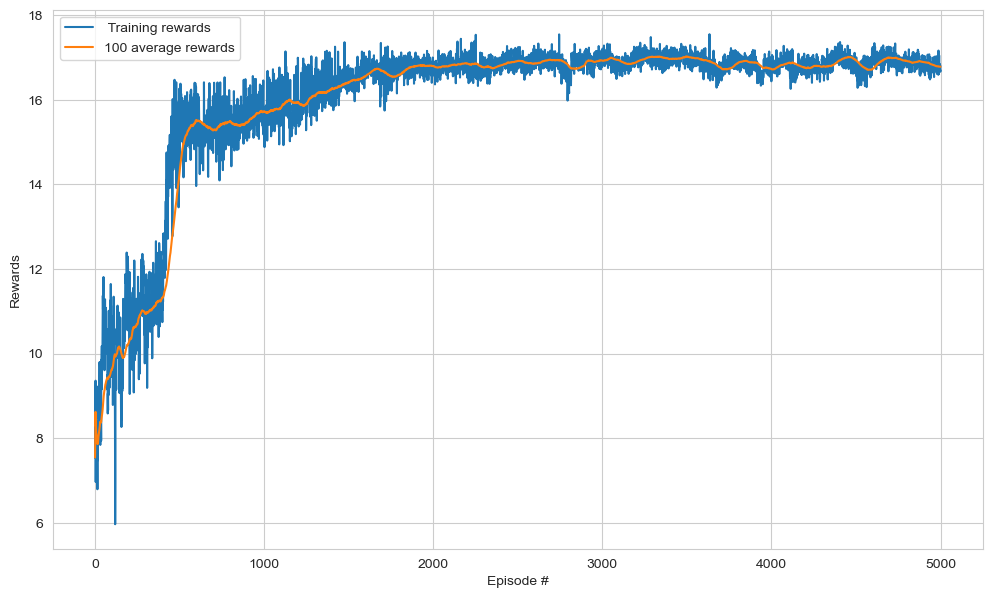

In [674]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(training_reward_list)+1), training_reward_list, label = " Training rewards")
plt.plot(np.arange(1, len(average_100)+1), average_100, label = "100 average rewards")
plt.legend()
plt.ylabel('Rewards')
plt.xlabel('Episode #')
plt.show()

In [94]:
 env.observation_space.shape[0]

10

In [131]:
torch.tensor([[-0.4771, -0.5752, -0.5794, -0.5693, -0.5457, -0.5490, -0.5777]]).numpy()[0]

array([[-0.4771, -0.5752, -0.5794, -0.5693, -0.5457, -0.549 , -0.5777]],
      dtype=float32)

In [126]:
np.clip(x, np.array([-1]*7), np.array([1]*7))

array([-0.47710001, -0.57520002, -0.5794    , -0.5693    , -0.54570001,
       -0.54900002, -0.57770002])

In [128]:
q_list = np.clip(x, np.array([-1]*7), np.array([1]*7))

In [125]:
np.array([1]*7)

array([7, 7, 7, 7, 7, 7, 7])

In [129]:
q_list

array([-0.47710001, -0.57520002, -0.5794    , -0.5693    , -0.54570001,
       -0.54900002, -0.57770002])

In [148]:
torch.tensor([[float(q_list[1])]])

tensor([[-0.5752]])

In [158]:
np.random.rand(7,)*2-1

array([ 0.93688388, -0.15074659, -0.07775299,  0.62621551,  0.82506041,
       -0.73978417, -0.03473599])

In [86]:
q_list

array([0., 0., 0., 0., 0., 0., 0., 0.])

# HSAC Top-Down

In [183]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        global eps_sac
        dist = Normal(0, eps_sac)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std)
        log_prob = Normal(mu, std).log_prob(mu + e * std) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob
        
    
    def get_action(self, state, add_noise=True):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        #state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mu, log_std = self.forward(state.unsqueeze(0))
        std = log_std.exp()
        global eps_sac        
        dist = Normal(0, eps_sac)

        e      = dist.sample().to(device)
        
        action = torch.tanh(mu + e * std).cpu()
        
        if add_noise != True:
            action = torch.tanh(mu).cpu()
            
        return action[0],std


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers

        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size+action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, action_prior="uniform"):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.target_entropy = -action_size  # -dim(A)
        self.alpha = 1
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=LR_ACTOR) 
        self._action_prior = action_prior
        
#         print("Using: ", device)
        
        # Actor1 Network 
        self.actor1_local = Actor(state_size, 1, random_seed).to(device)
        self.actor1_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR) 
        
        # Actor2 Network 
        self.actor2_local = Actor(state_size+1, num_catchments, random_seed).to(device)
        self.actor2_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)  
        
        # Critic Network (w/ Target Network)
        self.critic1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic2 = Critic(state_size, action_size, random_seed).to(device)
        
        self.critic1_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY) 

        # Replay memory
        #self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.memory = PrioritizedReplay(capacity=SAC_BUFFER_SIZE)
    def add_sample(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.push(state, action, reward, next_state, done)


    def step(self, c_k):
        # Learn, if enough samples are available in memory
        experiences = self.memory.sample(SAC_BATCH_SIZE, c_k)
        self.learn( experiences, GAMMA)
            
    
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state1 = torch.from_numpy(state).unsqueeze(0).float().to(device)
        action1, SAC_std1 = self.actor_local.get_action(state1)
        state2 = T.cat([action1, state1], dim=1)
        action2, _ = self.actor_local.get_action(state2)        
        action = T.cat([action1, action2], dim=1).detach()
        if add_noise != True:
            action1, _ = self.actor_local.get_action(state1, add_noise= False)
            action2, _ = self.actor_local.get_action(state2, add_noise= False)        
            action = T.cat([action1, action2], dim=1).detach()
        return action, SAC_std1.detach()

    def learn(self, experiences, gamma):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, idx, weights = experiences
        states      = torch.FloatTensor(np.float32(states)).to(device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(device)
        actions     = torch.cat(actions).to(device)#.unsqueeze(1)

        rewards     = torch.FloatTensor(rewards).to(device).unsqueeze(1) 
        dones       = torch.FloatTensor(dones).to(device).unsqueeze(1)
        weights    = torch.FloatTensor(weights).unsqueeze(1)
        #print(actions.shape)
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_action, log_pis_next = self.actor_local.evaluate(next_states)

        Q_target1_next = self.critic1_target(next_states.to(device), next_action.squeeze(0).to(device))
        Q_target2_next = self.critic2_target(next_states.to(device), next_action.squeeze(0).to(device))

        # take the mean of both critics for updating
        Q_target_next = torch.min(Q_target1_next, Q_target2_next).cpu()

        # Compute Q targets for current states (y_i)
        Q_targets = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target_next - self.alpha * log_pis_next.mean(1).unsqueeze(1).cpu()))
        #TD_L1 = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target1_next.cpu() - self.alpha * log_pis_next.mean(1).unsqueeze(1).cpu()))
        #TD_L2 = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target2_next.cpu() - self.alpha * log_pis_next.mean(1).unsqueeze(1).cpu()))
        # Compute critic loss
        Q_1 = self.critic1(states, actions).cpu()
        Q_2 = self.critic2(states, actions).cpu()
        td_error1 = Q_targets.detach()-Q_1#,reduction="none"
        td_error2 = Q_targets.detach()-Q_2
        critic1_loss = 0.5* (td_error1.pow(2)*weights).mean()
        critic2_loss = 0.5* (td_error2.pow(2)*weights).mean()
        prios = abs(((td_error1 + td_error2)/2.0 + 1e-5).squeeze())

        # Update critics
        # critic 1
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        # critic 2
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        self.memory.update_priorities(idx, prios.data.cpu().numpy())

        alpha = torch.exp(self.log_alpha)
        # Compute alpha loss
        actions_pred, log_pis = self.actor_local.evaluate(states)
        alpha_loss = - (self.log_alpha.cpu() * (log_pis.cpu() + self.target_entropy).detach().cpu()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        self.alpha = alpha
        # Compute actor loss
        if self._action_prior == "normal":
            policy_prior = MultivariateNormal(loc=torch.zeros(self.action_size), scale_tril=torch.ones(self.action_size).unsqueeze(0))
            policy_prior_log_probs = policy_prior.log_prob(actions_pred)
        elif self._action_prior == "uniform":
            policy_prior_log_probs = 0.0
   
        actor_loss = ((alpha * log_pis.squeeze(0).cpu() - self.critic1(states, actions_pred.squeeze(0)).cpu() - policy_prior_log_probs )*weights).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic1, self.critic1_target, TAU)
        self.soft_update(self.critic2, self.critic2_target, TAU)
                     

    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [184]:
class PrioritizedReplay(object):
    """
    Proportional Prioritization
    """
    def __init__(self, capacity, alpha=0.6, beta_start = 0.4, beta_frames=int(1e5)):
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1 #for beta calculation
        self.capacity   = capacity
        self.buffer     = deque(maxlen=capacity)
        self.pos        = 0
        self.priorities = deque(maxlen=capacity)
    
    def beta_by_frame(self, frame_idx):
        """
        Linearly increases beta from beta_start to 1 over time from 1 to beta_frames.
        
        3.4 ANNEALING THE BIAS (Paper: PER)
        We therefore exploit the flexibility of annealing the amount of importance-sampling
        correction over time, by defining a schedule on the exponent 
        that reaches 1 only at the end of
        learning. In practice, we linearly anneal 
        from its initial value 
        0 to 1
        """
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = max(self.priorities) if self.buffer else 1.0 # gives max priority if buffer is not empty else 1
        
#         self.buffer.append((state, action, reward, next_state, done))
#         self.priorities.append(max_prio)
        self.buffer.insert(0, (state, action, reward, next_state, done))
        self.priorities.insert(0, max_prio)

    
    def sample(self, batch_size, c_k):
        N = len(self.buffer)
        if c_k > N:
            c_k = N
            

        if N == self.capacity:
            prios = np.array(self.priorities)
        else:
            prios = np.array(list(self.priorities)[:c_k])
        
        #(prios)
        # calc P = p^a/sum(p^a)
        probs  = prios ** self.alpha
        P = probs/probs.sum()
        
        #gets the indices depending on the probability p and the c_k range of the buffer
        indices = np.random.choice(c_k, batch_size, p=P) 
        samples = [self.buffer[idx] for idx in indices]
        
        beta = self.beta_by_frame(self.frame)
        self.frame+=1
                
        #Compute importance-sampling weight
        weights  = (c_k * P[indices]) ** (-beta)
        # normalize weights
        weights /= weights.max() 
        weights  = np.array(weights, dtype=np.float32) 
        
        states, actions, rewards, next_states, dones = zip(*samples) 
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = abs(prio)

    def __len__(self):
        return len(self.buffer)

In [214]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 7    
Total_budget = num_years*budgetb
BPF = 2  #budget penalty factor


class SewerBudgetEnv10(Env):
    def __init__(self):
    
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1+num_catchments,))
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                                     high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), dtype=np.float32)
        self.state = self.reset()



    def reset(self):    
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB

        return self.state


    def step(self,action,render=False):
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        
        budget = budgetb*(1+action[0]*0.15)
#         print(budget)
        self.RB -= budget/Total_budget
#         if eps > random.random():
#             annual_plan = np.random.randint(2, size=self.components)
#             pcost = Tadf[Tadf.action == tuple(annual_plan)].cost.values[0]

#         else:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond, int(self.time+0.001))
            
#         if episodes*7 >= MIN_REPLAY_SIZE:
#             annual_plan, _ , pcost = hplan(budget, trans, self.cond)
#         else:
#             annual_plan, _ , pcost = plan(budget, trans, self.cond)
        
        annual_plan, _ , pcost = hplan(budget, trans, self.cond, self.state)    

        # deterioration
#         print(annual_plan)
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])
        
        
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:7] = (avg_cond-1)/4
        self.state[7] = (s_cond-1)/4
        self.state[8] = self.time/num_years
        self.state[9] = self.RB
        
        # calculate reward
        reward = 1 - self.state[num_catchments]
        if done:
            if self.RB < 0:
#                 reward -= 0.1
                reward += (self.RB*BPF - 0.1)
                
        if pcost > budgetb*(1+Tol):        
#             reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)
            reward -= 1

        elif pcost < budgetb*(1-Tol):
#             reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)
            reward -= 1
        info = {}
        return self.state, reward, done, annual_plan
    
    def render(self):
        # Implement viz
        pass

In [215]:
"""MIP example that solves an assignment problem."""

cond = np.stack(dfCL.Init.values)
budget = 10000
q_list = np.zeros((num_catchments+1,))

def hplan(budget = 10000, trans = trans, cond = cond , state = None):

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if plan j is addopted for catchment j.
    x = {}
    for C in range(len(catchments)):
        x[C] = solver.BoolVar(f'x[{C}]')

    # Constraints
      

    # Yearly budget constraint.

    yearlyB_terms = [x[C]* dfCL.Len[C] * Ucost for C in range(len(catchments))]
    solver.Add(solver.Sum(yearlyB_terms) <= budget)


      
    # Objective
    
        # random 
    if (eps/1) > random.random():
        
        objective_terms = []
        for C in range(len(catchments)):
            objective_terms.append((1-((np.dot(S,np.matmul(cond[C],trans[C, 1]* x[C]+ trans[C, 0]*(1-x[C])))-1)/4))*dfCL.Len[C])                           
        
        
#         qrand = np.random.rand(7,)*2-1
#         objective_terms = []
#         for C in range(len(catchments)):
#             objective_terms.append((qrand[C]* x[C]))

    else: 
        objective_terms = []
        for C in range(len(catchments)):
    #             objective_terms.append(q_list[C][1]* x[C]+ q_list[C][0]*(1-x[C]))
            objective_terms.append(q_list[C+1]* x[C])
            
    solver.Maximize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()

    # Print solution.
    sol = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
#         print(f'Total cost = {solver.Objective().Value()}\n')
        for C in range(len(catchments)):
            sol.append(int(x[C].solution_value()))
    else:
        print('No solution found.')

    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(np.dot(S,np.matmul(cond[C],trans[C, 1]*x[C].solution_value()+ trans[C, 0]*(1-x[C].solution_value())))*dfCL.Len[C])  
    
    objective = sum(objective_terms)/dfCL.Len.sum()
    
    cost =  sum([x[C].solution_value()* dfCL.Len[C] * Ucost for C in range(len(catchments))])
    sollist.append(sol)
    return sol, objective, cost



In [216]:
def HSAC(n_interactions, print_every=10):
    
    scores_deque = deque(maxlen=args.print_every)
    std_deque = deque(maxlen=args.print_every*num_years)
    state = env.reset()
    episode_K = 0
    score = 0
    eta_0 = 0.996
    eta_T = 1.0
    episodes = 1
    max_ep_len = 500 # original = 1000
    c_k_min = 2500 # original = 5000
    t = 0   
    global eps
    global eps_sac, agent, q_list, eps_noise
    #for t in range(1, int(n_interactions)+1):
    while t < n_interactions:
    
        for i in range(max_ep_len):
            t +=1

            if eps_noise > random.random():
                action, SAC_std = agent.act(state)
            else:
                action, SAC_std = agent.act(state, add_noise= False)
            action_v = action.numpy()[0]
            action_v = np.clip(action_v, np.array([action_low]*action_size), np.array([action_high]*action_size))
            q_list = action_v+1
            std_deque.append(SAC_std[0][0].cpu().numpy()[0]) 
            
            next_state, reward, done, annual_plan = env.step(action_v)              
            
            agent.add_sample(state, action, reward, next_state, done)
            eta_t = eta_0 + (eta_T - eta_0)*(t/n_interactions)
            state = next_state
            score += reward

            episode_K +=1
        
            if done or i == max_ep_len:
                episodes += 1
                for k in range(1,episode_K):
                    c_k = max(int(agent.memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                    agent.step(c_k)
                
                scores_deque.append(score)
                writer.add_scalar("Reward", score, episodes)
                writer.add_scalar("average_X", np.mean(scores_deque), episodes)
                print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.3f}  \tEpsilon: {:.3f}'.format(episodes, score, np.mean(scores_deque),eps_noise), end="")
                if episodes % print_every == 0:
                        print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.3f}  SD100 Score: {:.5f}  SAC SD: {:.5f}  \tEpsilon: {:.3f}'.format(episodes, np.max(scores_deque), np.mean(scores_deque), np.std(scores_deque), np.mean(std_deque),eps_noise))
                        sol = np.array(sollist).T.flatten().tolist()
                        printPlanInfo(sol)
                        
                state = env.reset()
                episode_K = 0
                score = 0
                break
        
            
#         if eps > 0.0001 : 
#             eps = eps*0.999
#         if (episodes % 100 == 0) and  (episodes < 0):
#             agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed, action_prior="uniform")
#         if (BPF > 2) and (episodes > 4500):
#             BPF -= 0.0015
            
#         if eps_sac > 0.01: 
#             eps_sac =  eps_sac*0.9993 

#         if eps_noise > 0.001: 
#             eps_noise =  eps_noise*0.996  
        
        # Test the greedy policy
#         if episodes % 1000 ==0: 
#             total_training_rewards = 0
#             state = env.reset()
#             done = False
#             reward_list = []
#             action_list = []
#             while not done:
#                 action = agent.act(state, add_noise= False)
#                 action_v = action[0].numpy()
#                 action_v = np.clip(action_v*action_high, action_low, action_high)
#                 for C in range (num_catchments):
#                     agent_obs = np.array([action_v[0],state[C],state[7],state[8],state[9]])                       
#                     q_list[C] = get_qs(cmodel[C],agent_obs)
#                 next_state, reward, done, info = env.step(action_v)
#                 action_list.append(action_v)
#                 reward_list.append(reward)
#                 state = next_state
#                 total_training_rewards += reward
#             print("Greedy result:       ",(1-(total_training_rewards/num_years))*4+1)
#             state = env.reset()
    
 
    torch.save(agent.actor_local.state_dict(), args.info + ".pt")
        
    

In [217]:
parser = argparse.ArgumentParser()
parser.add_argument("-env", type=str, default="Pendulum-v0", help="Name of the Environment")
parser.add_argument("-frames", type=int, default=50_000, help="Number of frames to train, default = 20000")
parser.add_argument("-bs", "--buffer_size", type=int, default= int(1e7), help="Size of the Replay buffer, default= 1e6")
parser.add_argument("-bsize", "--batch_size", type=int, default=256, help="Batch size for the optimization process, default = 256")
parser.add_argument("-seed", type=int, default=0, help="Seed for the env and torch network weights, default is 0")
parser.add_argument("-lr", type=float, default=5e-4, help="Learning Rate, default 5e-4")
parser.add_argument("-g", type=float, default=0.99, help="discount factor gamma, default = 0.99")
parser.add_argument("-wd", type=float, default=0.00, help="Weight decay, default = 0")
parser.add_argument("-ls", "--layer_size", type=int, default=256, help="Number of nodes per neural network layer, default = 256")
parser.add_argument("--print_every", type=int, default=100, help="Prints every x episodes the average reward over x episodes")
parser.add_argument("-info", type=str, default="SewerBudget", help="tensorboard test run information")
parser.add_argument("-device", type=str, default="cuda:0", help="Change to CPU computing or GPU, default=cuda:0")
parser.add_argument("--saved_model", type=str, default=None, help="Load a saved model to perform a test run!")
parser.add_argument("-t", "--tau", type=float, default=1e-2, help="Softupdate factor tau, default is 1e-2")
args = parser.parse_args(args=[])

In [ ]:
# dis = 20
# e = 1e-4
sollist=deque(maxlen=num_years)
agent = Agent(state_size=num_catchments+3, action_size=num_catchments+1, random_seed=seed, action_prior="uniform") #"normal"

if __name__ == "__main__":
    
    
    seed = args.seed
    SAC_BUFFER_SIZE = args.buffer_size
    SAC_BATCH_SIZE = args.batch_size        # minibatch size
    n_interactions = args.frames
    GAMMA = args.g            # discount factor
    TAU = args.tau            # for soft update of target parameters
    LR_ACTOR = args.lr         # learning rate of the actor 
    LR_CRITIC = args.lr       # learning rate of the critic
    WEIGHT_DECAY = args.wd#1e-2        # L2 weight decay
    HIDDEN_SIZE = args.layer_size
    saved_model = args.saved_model
    
    eps = 0.0
    eps_sac = 1.0
    eps_noise = 1.0
    exploration_frames = 60000
    
    env = SewerBudgetEnv10()
#     env_name = args.env
#     device = args.device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     env = gym.make(env_name)

    
    env.seed(seed)
    np.random.seed(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_high = env.action_space.high[0]
    action_low = env.action_space.low[0]
    writer = SummaryWriter("runs/"+args.info)

    start_time = time.time()

    if saved_model != None:
        agent.actor_local.load_state_dict(torch.load(saved_model))
        play()
    else:    
        HSAC(n_interactions=args.frames, print_every=args.print_every)

    end_time = time.time()
    env.close()
    print("Training took: {} min".format((end_time-start_time)/60))
    #writer.add_hparams()

C:\Users\Admin\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Episode 100  Reward: 3.27  Average100 Score: 2.673  SD100 Score: 0.60688  SAC SD: 0.73973  	Epsilon: 1.000
Plan for each Catchment:
1 : [0, 0, 0, 0, 0, 0, 0]
11 : [1, 1, 1, 1, 1, 1, 1]
12 : [0, 0, 0, 0, 0, 0, 0]
13_25 : [1, 1, 1, 1, 1, 1, 1]
17 : [0, 0, 0, 0, 0, 0, 0]
18 : [1, 1, 1, 1, 1, 1, 1]
19 : [1, 1, 1, 0, 1, 1, 1]

Yearly Budget violations =  (1, 0.0927668941176472)

Total Budget violations =  (0, 0)

Minimum flush violations =  (3, 0.7015267016569958)

Required budget for this plan:  [9294.1, 9294.1, 9294.1, 7711.5, 9294.1, 9294.1, 9294.1]

Total required budget:  63476.0

Network objective without penalty:  3.1699087362771854

                 1  2  3  4  5  6  7
Catchment_Group                     
1                0  0  0  0  0  0  0
11               1  1  1  1  1  1  1
12               0  0  0  0  0  0  0
13_25            1  1  1  1  1  1  1
17               0  0  0  0  0  0  0
18               1  1  1  1  1  1  1
19               1  1  1  0  1  1  1
Episode 200  Reward: 3.

Episode 1000  Reward: 3.86  Average100 Score: 3.604  SD100 Score: 0.11955  SAC SD: 0.17625  	Epsilon: 1.000
Plan for each Catchment:
1 : [0, 1, 1, 0, 0, 0, 1]
11 : [1, 1, 1, 1, 1, 1, 1]
12 : [0, 0, 0, 1, 0, 1, 0]
13_25 : [1, 0, 0, 0, 1, 0, 0]
17 : [0, 0, 0, 0, 0, 0, 0]
18 : [1, 1, 1, 0, 1, 0, 1]
19 : [1, 1, 1, 0, 1, 0, 1]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (1, 0.3261421899076995)

Required budget for this plan:  [9294.1, 8923.9, 8923.9, 9483.7, 9294.1, 9483.7, 8923.9]

Total required budget:  64327.1

Network objective without penalty:  2.919040037347067

                 1  2  3  4  5  6  7
Catchment_Group                     
1                0  1  1  0  0  0  1
11               1  1  1  1  1  1  1
12               0  0  0  1  0  1  0
13_25            1  0  0  0  1  0  0
17               0  0  0  0  0  0  0
18               1  1  1  0  1  0  1
19               1  1  1  0  1  0  1
Episode 1100  Reward: 3.87  Average100 S

In [207]:
total_training_rewards = 0
state = env.reset()
done = False
reward_list = []
action_list = []
sollist=deque(maxlen=num_years)
eps = 0
while not done:
    
    action, SAC_std = agent.act(state, add_noise= False)
    action_v = action[0].numpy()
    action_v = np.clip(action_v*action_high, action_low, action_high)
    q_list = action_v+1
    print('action:')
    print(action_v)
    print('******************')
    print(q_list)
    next_state, reward, done, info = env.step(action_v)
    action_list.append(action_v)
    reward_list.append(reward)
    state = next_state
    total_training_rewards += reward
((1-(total_training_rewards/num_years))*4+1)

action:
[-0.14557205 -0.99999815 -0.8861278   0.45870107 -0.99994767 -0.9805541
 -0.9978642  -0.999979  ]
******************
[8.5442793e-01 1.8477440e-06 1.1387217e-01 1.4587011e+00 5.2332878e-05
 1.9445896e-02 2.1358132e-03 2.0980835e-05]
action:
[ 0.99999917  0.99860513 -0.9988132  -0.9913134   0.99948823  0.99870354
  0.9917274  -0.92614377]
******************
[1.9999992e+00 1.9986051e+00 1.1867881e-03 8.6866021e-03 1.9994882e+00
 1.9987035e+00 1.9917274e+00 7.3856235e-02]
action:
[ 0.9815383  -1.         -0.838542   -0.04467497 -0.9980079   0.91319406
 -0.9999452  -1.        ]
******************
[1.9815383e+00 0.0000000e+00 1.6145802e-01 9.5532501e-01 1.9921064e-03
 1.9131941e+00 5.4776669e-05 0.0000000e+00]
action:
[-0.27958277 -0.99772936 -0.524042   -0.0638728  -0.9365656  -0.1315506
 -0.6277976  -0.99999994]
******************
[7.2041726e-01 2.2706389e-03 4.7595799e-01 9.3612719e-01 6.3434422e-02
 8.6844939e-01 3.7220240e-01 5.9604645e-08]
action:
[-0.13973409 -0.9765993  -0.99

2.53183984087438

In [208]:
sol = np.array(sollist).T.flatten().tolist()
printPlanInfo(sol)

Plan for each Catchment:
1 : [0, 1, 0, 0, 0, 0, 1]
11 : [1, 0, 0, 1, 1, 0, 1]
12 : [1, 0, 0, 1, 0, 0, 0]
13_25 : [0, 1, 0, 0, 1, 0, 0]
17 : [0, 0, 1, 0, 0, 1, 0]
18 : [0, 1, 0, 0, 1, 0, 1]
19 : [0, 1, 0, 0, 1, 0, 1]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (0, 0.0)

Required budget for this plan:  [9483.7, 11499.4, 10155.7, 9483.7, 9294.1, 10155.7, 8923.9]

Total required budget:  68996.1

Network objective without penalty:  2.4912132292557976

                 1  2  3  4  5  6  7
Catchment_Group                     
1                0  1  0  0  0  0  1
11               1  0  0  1  1  0  1
12               1  0  0  1  0  0  0
13_25            0  1  0  0  1  0  0
17               0  0  1  0  0  1  0
18               0  1  0  0  1  0  1
19               0  1  0  0  1  0  1
